In [1]:
import pandas as pd #module to work with dataframes
import networkx as nx #module to work with networks
import numpy as np
import scipy as scpy
from Functions import *
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

# Network Structure II: Community structure and mixing patterns (community-scale)

## Connected components

In the simple network we saw at the start of the previous notebook we saw that for **every** pair of nodes, we can find a path connecting them. This is the definition of a **connected graph**. We can check this property for a given graph:

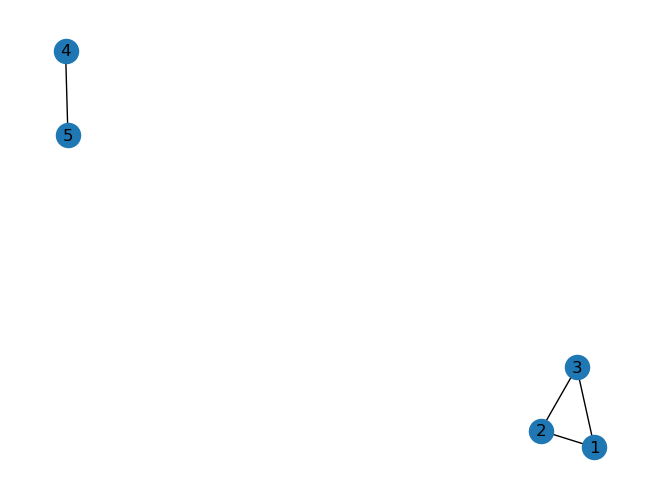

In [2]:
G = nx.Graph()
nx.add_cycle(G, (1,2,3))
G.add_edge(4,5)
nx.draw(G, with_labels=True)

In [3]:
nx.is_connected(G)

False

In graph theory, a **connected component** (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths.  
While visually, we can identify two connected components in that graph, it is not always so simple, and we need a way to verify this. 
NetworkX provides a function to let us find all of the connected components:`nx.number_connected_components(G)`.


In [4]:
nx.number_connected_components(G)

2

The `nx.connected_components(G)` function takes a graph and returns a list of sets of node names, one such set for each connected component. Verify that the two sets in the following list correspond to the two connected components in the drawing of the graph above:

In [5]:
list(nx.connected_components(G)) # see that they match the components in the graph figure

[{1, 2, 3}, {4, 5}]

> In case you're not familiar with Python sets: they are **unordered** collections of items **without duplicates**. These are useful for collecting node names because node names should be unique. We can get the number of items in a set with the `len` function:

In [6]:
components = list(nx.connected_components(G)) #get number of nodes in the first component
len(components[0])

3

We often care about the **largest connected component**, which is sometimes referred to as the **core** of the network. We can make use of Python's builtin `max` function in order to obtain the largest connected component. By default, Python's `max` function sorts things in lexicographic (i.e. alphabetical) order, which is not helpful here. We want the maximum connected component when sorted in order of their sizes, so we pass `len` as a key function:

In [7]:
max(nx.connected_components(G), key=len)

{1, 2, 3}

While it's often enough to just have the list of node names, sometimes we need the actual subgraph consisting of the largest connected component. One way to get this is to pass the list of node names to the `G.subgraph()` function:

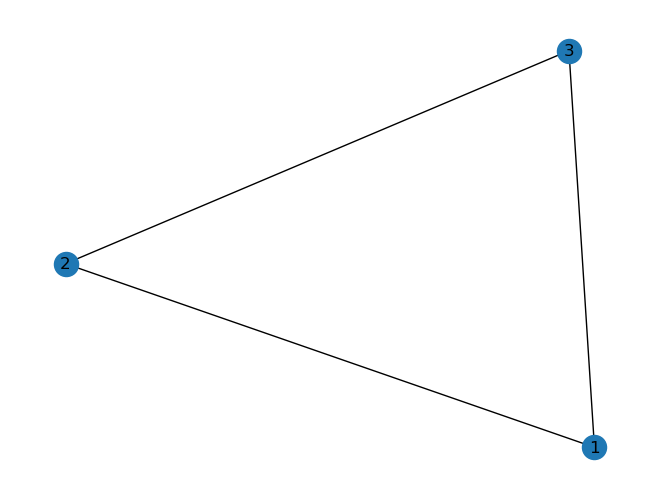

In [8]:
core_nodes = max(nx.connected_components(G), key=len)
core = G.subgraph(core_nodes)

nx.draw(core, with_labels=True)

### Directed components
Directed networks have two kinds of connectivity. **Strongly connected** means that there exists a directed path between every pair of nodes, i.e., that from any node we can get to any other node while following edge directionality. Think of cars on a network of one-way streets: they can't drive against the flow of traffic.

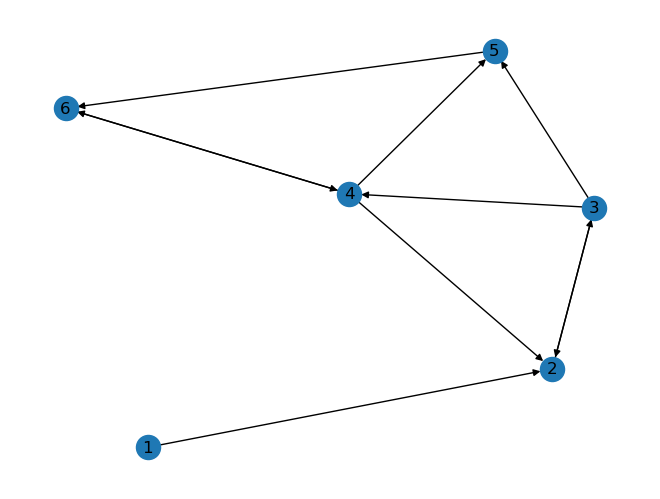

In [9]:
D = nx.DiGraph() #lets  use the same small directed network
D.add_edges_from([
    (1,2),
    (2,3),
    (3,2), (3,4), (3,5),
    (4,2), (4,5), (4,6),
    (5,6),
    (6,4),
])
nx.draw(D, with_labels=True)

In [10]:
nx.is_strongly_connected(D)

False

**Weakly connected** means that there exist a path between every pair of nodes, regardless of direction. Think about pedestrians on a network of one-way streets: they walk on the sidewalks so they don't care about the direction of traffic.

In [11]:
nx.is_weakly_connected(D)

True

> Note 1: If a network is strongly connected, it is also weakly connected. The converse is not always true, as seen in this example.

> Note 2: The `is_connected` function for undirected graphs will raise an error when given a directed graph.

In the directed case, instead of `nx.connected_components` we now have `nx.weakly_connected_components` and `nx.strongly_connected_components`:

In [12]:
list(nx.weakly_connected_components(D))

[{1, 2, 3, 4, 5, 6}]

In [13]:
list(nx.strongly_connected_components(D))

[{2, 3, 4, 5, 6}, {1}]

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 14</h4>
Let's work with the network of US air travel routes again:
    
- 1) Is it possible to travel from any airport in the US to any other airport in the US, possibly using connecting flights? 
- 2) How many airports are in the component with less nodes?
    
![title](./images/figure6.png)
</div>

In [14]:
#write your code here. The network is already loaded
G = nx.read_graphml('./data/openflights_usa.graphml.gz')

In [15]:
# %load ./snippets/ex14.py

> In general non-connected networks can generate problems in some algorithm (closeness centrality for example) and usually we will be only interested in the **largest component**, also known as **giant component** or **network core**. In some cases you will may need to yust study this **giant component**. If you remember what we used before to measure network integrity was the size of the giant component. 

## Partitions

A **partition** of a graph is a separation of its nodes into disjoint groups. Consider the following graph:

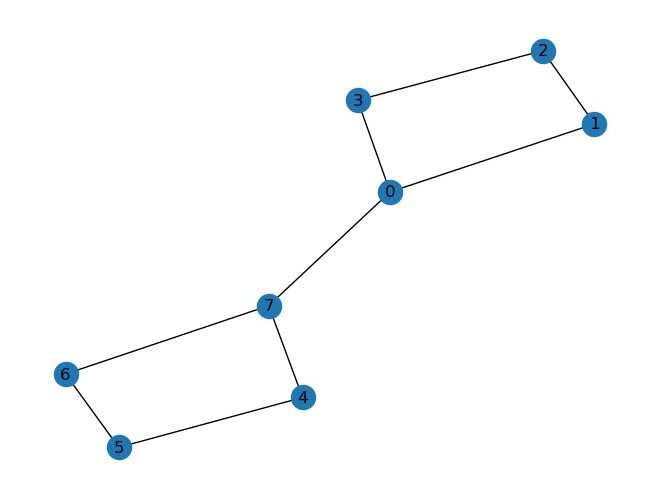

In [16]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

The following is an example of a partition of these nodes:

In [17]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

Observe that **every node** in the graph is **in exactly one of the sets** in the partition. Formally, a partition is a list of sets such that every node is in exactly one set. NetworkX can verify that our partition is valid:

In [18]:
nx.community.is_partition(G, partition)

True

When developing **community detection algorithms**, we often make use of a *partition map*, which is a dictionary mapping node names to a partition index. This is useful for quickly comparing if two nodes are in the same cluster in the partition:

In [19]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In this dictionary, the keys are the node names and two nodes will have the same value if they are in the same partition:

In [20]:
partition_map[0] == partition_map[7]

True

We can visualize our partition by drawing the graph with nodes colored by their partition membership, similar to how we colored the gomponents:

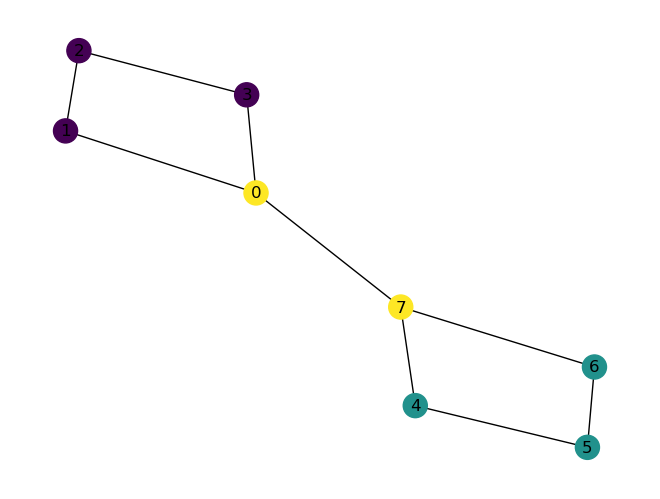

In [21]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

There are two **trivial partitions** in all networks:

1. The partition with one set containing every node;
2. The partition with N sets, each containing a single node.

A valid partition thus contains between 1 and N sets.

Feel free to experiment by changing the partition above and running the subsequent cells.

## Modularity

At a high level, network community detection consists of finding a partition that achieves good separation between the groups of nodes. Before we get into how to find good partitions of a graph, we need an objective -- a way to measure how good the partition is. Modularity is one such objective function.

The modularity of a graph partition compares the number of intra-group edges with a random baseline. Higher modularity scores correspond to a higher proportion of intra-group edges, therefore fewer inter-group edges and better separation of groups.

For weighted undirected networks, we have
\begin{equation}
    Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
    \label{eq:wmodul}
\end{equation}
where 
* $W$ is the total weight of the links of the network,
* $W_C$ the total weight of the internal links of cluster $C$, and
* $s_C$ the total strength of the nodes of $C$.

The total weight $W$ is half the total strength for the same reason that the number of edges $L$ is half the total degree. While this formula may look a bit complicated, it's straightforward to write code to compute the sum, but still NetworkX provides a modularity function that is more efficient than one I can write: `community.quality.modularity`

In [22]:
nx.community.quality.modularity(G, partition)

0.2222222222222222

Let's compare this to a partition we would suspect to have higher modularity:

In [23]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

### Zachary's Karate Club
When writing and testing community-detection algorithms, it helps to make use of benchmark networks: graphs with a known, "natural" community structure. Perhaps the most famous benchmark graph is Zachary's Karate Club. It contains 34 nodes, representing members of a karate club whose interactions were monitored over a period of three years by researchers. Links in this graph connect individuals interacting outside club activities, a proxy for social ties.

During the course of the study, a conflict between the instructor Mr. Hi (node 0) and the president, or Officer (node 33) led to a split of the club into separate groups led by Mr. Hi and Officer. In this case we know whom each member of the group followed after the split, providing empirical community labels: those members who followed Mr. Hi are said to be one community and those following the Officer make up the other.

For this graph, we assume that the post-split group composition was largely driven by the social ties: members of the same friend groups would want to be part of the same club after the split. We thus expect a good community-detection algorithm to predict the post-split group composition with high accuracy.

Zachary's karate club is such a popular benchmark graph that it has its own function in NetworkX:

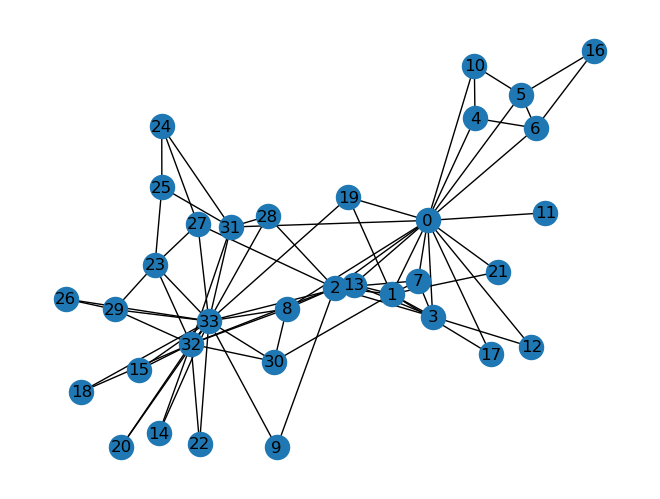

In [24]:
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)

Each node in this graph has a `'club'` attribute, indicating whether the member followed the instructor or the president after the split:

In [25]:
G.nodes[0]

{'club': 'Mr. Hi'}

In [26]:
G.nodes[9]

{'club': 'Officer'}

We can visualize these labels by coloring each node according to its `'club'` attribute:

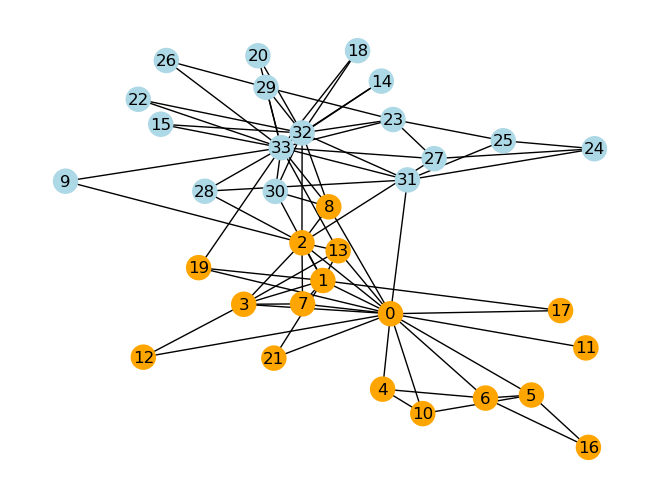

In [27]:
G = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[G.nodes[n]['club']] for n in G.nodes]
nx.draw(G, node_color=node_colors, with_labels=True)

This separation looks good, in that there are relatively few inter-community links as opposed to intra-community links. Let's create a graph partition based on these labels and measure its modularity.

We can do this by creating a dictionary of two sets, one for each value of the nodes' `'club'` attribute, then assigning the nodes to the corresponding set. 

In [28]:
groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in G.nodes:
    club = G.nodes[n]['club']
    groups[club].add(n)
groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}

In [29]:
empirical_partition = list(groups.values())

In [30]:
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

### Comparison to a random partition

For the sake of comparison, let's generate a random partition of this network and check its modularity. We would expect a modularity close to zero in this case.

We will asign nodes randomly between two partitions:

In [31]:
rnd_groups={1:set(),2:set()} #create the dictionary to store if the node goes to the group 1 or 2
for n in G.nodes:
    club = rnd.randint(1,2) #choose groups randomly
    rnd_groups[club].add(n) #add node to the set
rnd_groups
rnd_partition = list(rnd_groups.values())

We can visualize this partition and observe that the communities are much less natural-looking, as we would expect from a random assignment.

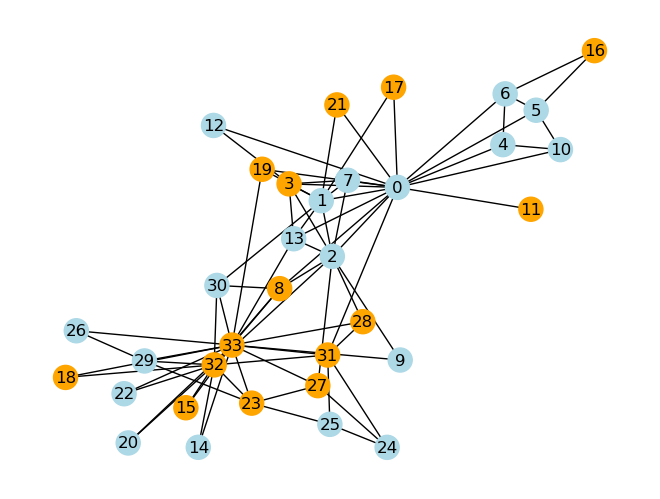

In [32]:
random_node_colors = ['orange' if n in rnd_groups[1] else 'lightblue' for n in G.nodes] #remember is just a list of color, we check the random group of each node
nx.draw(G, node_color=random_node_colors, with_labels=True)

### Best partitions
To obtain the best partition of the Zachary Karate Club graph into two groups, wecan use community detection algorithms that allow specifying the number of partitions, such as the **Girvan-Newman**. This algorithm works by iteratively removing edges with the highest betweenness centrality to split the graph into components. We can calculate the best parition for a given number of components like this:

In [33]:
partition_GN = girvan_newman_partition(G, num_partitions=2)
partition_GN

[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

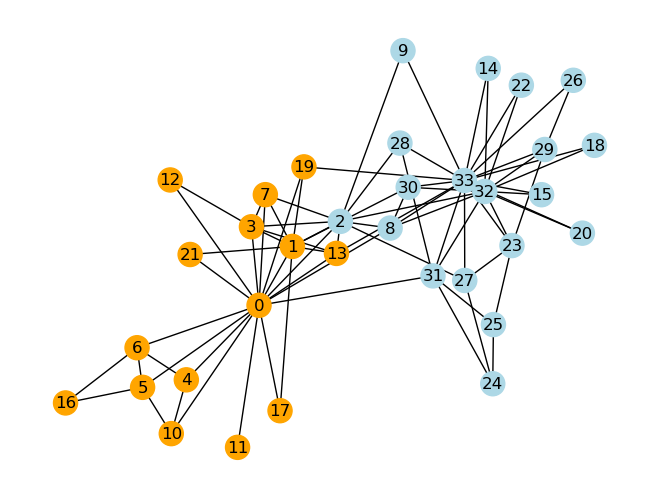

In [34]:
best_node_colors = ['orange' if n in partition_GN[0] else 'lightblue' for n in G.nodes]
nx.draw(G, node_color=best_node_colors, with_labels=True)

What the algorithm does to find the best partition is maximize the modularity. Let's see the modularity of the three partitions we have:

In [35]:
nx.community.quality.modularity(G, empirical_partition)

0.39143756676224206

In [36]:
nx.community.quality.modularity(G, rnd_partition)

0.025102603024680953

In [37]:
nx.community.quality.modularity(G, partition_GN)

0.3476602762317048

The Louvain algorithm is frequently used to obtain groups in networks too, but it does not allows to specify the number of clusters

In [38]:
partition_Louvain=nx.community.louvain_communities(G)
nx.community.quality.modularity(G, partition_Louvain)

0.4276718952043627

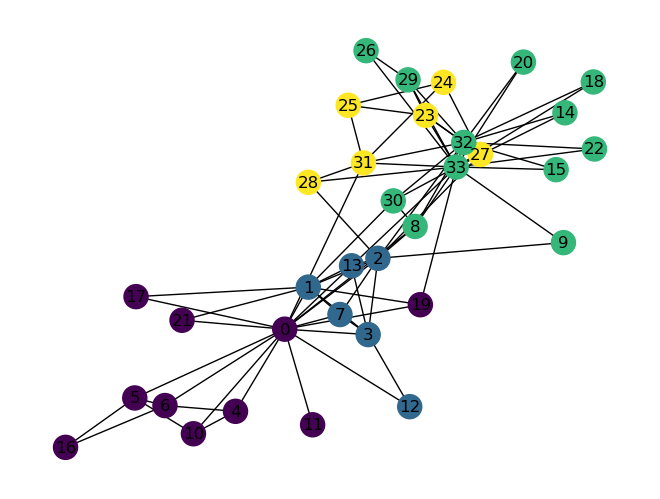

In [39]:
best_partition_map = create_partition_map(partition_Louvain)
node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

> Note1: Be careful with modularity, as best communities may not have much sense. Alwas **try to have an idea of what can be behind the group formation** and test that. 

> Note 2: While both methods can be aused in weighted networks automatically, louvain method only works in undirected graphs. For directed graphs see the Leiden algorithm, an improved version of Louvain, supports directed graphs by using a modularity function that accounts for directionality. It is in another library (leidenalg)

> Note 3: Girvan Newman algorithm can be used in weighted networks, but we need to specify we want to use the weighted betweennes centrality like this_ `community.girvan_newman(G, most_valuable_edge=nx.edge_betweenness_centrality_weighted)`

## Nestedness

The level of nestedness of the mutualistic matrix is usually estimated by means of appropriate software. However, Bastolla et al.  introduced an explicit definition of nestedness that makes the calculation more straightforward and had the advantage of being related to the form of the matrix of interactions. 

$$
\eta_{B}=\frac{\sum_{i<j}\hat{n}_{ij}}{\sum_{i<j}\min(k_{i},k_{j})},
$$
Here min(, ) refers to the smaller of the two values and , and the number of shared symbiotic partners,
$\hat{n}_{ij}=\sum_{l}\hat{a}_{il}\hat{a}_{lj}=(\hat{a}^{2})_{ij}$
This nestedness index ranges from zero to one, and is highly correlated with previous measures of nestedness.



In [40]:
filename="./data/WoL_fugivory/1.csv" 
Idf1=pd.read_csv(filename, header=0, index_col=0)
B1 = nx.Graph()
# Add producers (rows) and consumers (columns) as nodes
plants1 = Idf1.index
animals1 = Idf1.columns
B1.add_nodes_from(plants1, bipartite="plant")  # Set for producers
B1.add_nodes_from(animals1, bipartite="animal")  # Set for consumers
    # Add edges for non-zero interactions, we can also use the matrix directly
for plant in plants1:
    for animal in animals1:
        if Idf1.loc[plant, animal] != 0:
            B1.add_edge(plant, animal)
            

In [41]:
#since the function takes the matrix lets convert the network to amtrix form
Amat = nx.to_pandas_adjacency(B1) #get full adjacency matrix
Imat = Amat.loc[list(plants1), list(animals1)] #subselect the A vs P interactions
eta=nestedness2(Imat)
eta

0.520891364902507

In [42]:
filename="./data/WoL_fugivory/2.csv" 
Idf2=pd.read_csv(filename, header=0, index_col=0)
B2 = nx.Graph()
# Add producers (rows) and consumers (columns) as nodes
plants2 = Idf2.index
animals2 = Idf2.columns
B2.add_nodes_from(plants2, bipartite="plant")  # Set for producers
B2.add_nodes_from(animals2, bipartite="animal")  # Set for consumers
    # Add edges for non-zero interactions, we can also use the matrix directly
for plant in plants2:
    for animal in animals2:
        if Idf2.loc[plant, animal] != 0:
            B2.add_edge(plant, animal)
    

In [43]:
#since the function takes the matrix lets convert the network to amtrix form
Amat = nx.to_pandas_adjacency(B2) #get full adjacency matrix
Imat = Amat.loc[list(plants2), list(animals2)] #subselect the A vs P interactions
eta2=nestedness2(Imat)
eta2        
Q2=nx.community.modularity(B2,nx.community.louvain_communities(B2))
print(eta2,Q2)

0.5520751761942052 0.36437673130193904


<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 15</h4>
    
Load the Tronqueira frugivory network, and measure its **nestedness** and **modularity**.  The matrix is located at: "./data/WoL_Tronqueira/tronqueira.csv" (hint: you already loaded it in the first class)

- 1. What is the value of nestedness?
- 2. What is its modularity?
- 3. How do they compare to those from the previous one? (hit: just plot the values of nestedness vs the values of modularity)

</div>

In [44]:
#your code here

Text(0, 0.5, 'modularity')

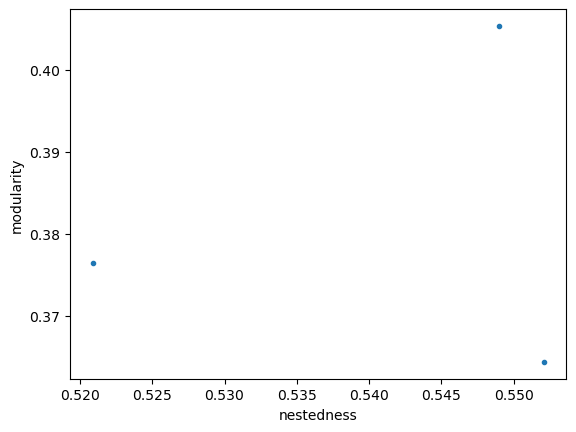

In [45]:
# %load ./snippets/ex15.py
#Read the Incidence matrix
filename="./data/WoL_Tronqueira/tronqueira.csv"
Idf=pd.read_csv(filename, header=0, index_col=0)
#print(Idf.head()) #allways print wath you import!!!!!
Idf=Idf.drop("Number of droppings analysed\"", axis=0)

# Initialize an empty bipartite graph
B = nx.Graph()

# Add producers (rows) and consumers (columns) as nodes
plants = Idf.index
animals = Idf.columns

# Add nodes with a bipartite identifier
B.add_nodes_from(plants, bipartite="plant")  # Set for producers
B.add_nodes_from(animals, bipartite="animal")  # Set for consumers

# Add edges for non-zero interactions, we can also use the matrix directly
for plant in plants:
    for animal in animals:
        if Idf.loc[plant, animal] != 0:
            B.add_edge(plant, animal)

            #since the function takes the matrix lets convert the network to amtrix form
Amat_T = nx.to_pandas_adjacency(B) #get full adjacency matrix
Imat_T = Amat_T.loc[list(plants), list(animals)] #subselect the A vs P interactions

eta_T=nestedness2(Imat_T)
Q_T=nx.community.modularity(B,nx.community.louvain_communities(B))


#modularity of the other network:
Q=nx.community.modularity(B1,nx.community.louvain_communities(B1))

plt.plot([eta, eta2,eta_T],[Q,Q2,Q_T],'.')
plt.xlabel("nestedness")
plt.ylabel("modularity")

# Network Structure III: Meso-scale patterns

## Triangles

The first structure that we are going to learn about is **triangles**.
Triangles are super interesting!
They are what one might consider to be
"the simplest complex structure" in a graph.
Triangles can also have semantically-rich meaning depending on the application.
To borrow a bad example, love triangles in social networks are generally frowned upon,
while on the other hand, when we connect two people that we know together,
we instead _complete_ a triangle.

NetworkX provides an `nx.triangles(G, node)` function.
It returns the number of triangles that a node is involved in.

Let's see how this works in a network of physicians, captures innovation spread among 246 physicians in for towns in Illinois, meaning that the physicians trust each other.

In [2]:
G=load_physicians_network()

NameError: name 'load_physicians_network' is not defined

In [47]:
nx.triangles(G,2)

3

In [48]:
get_triangle_neighbors(G,2)

{11, 39, 40, 42, 110}

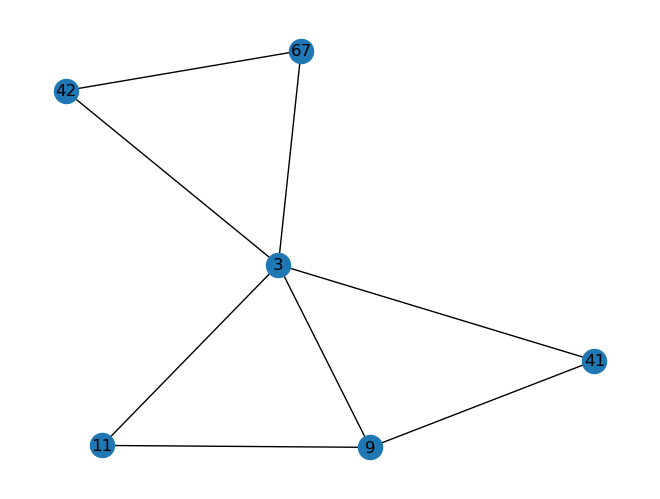

In [49]:
plot_triangle_relations(G, 3)

## Clustering

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes.
Two versions of this measure exist: the global and the local. The global version (`nx.transitivity(G)`) was designed to give an overall indication of the clustering in the network, whereas the local (`nx.clustering(G,node)`) gives an indication of the extent of "clustering" of a single node. 

The global clustering coefficient is the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed). As an alternative to the global clustering coefficient, the overall level of clustering in a network is measured by Watts and Strogatz as the average of the local clustering coefficients of all the vertices (`nx.average_clustering(G)`). This measure is very relevant in social networks, where "the frieds of your friends tend to be your friends".

 
When nodes have a high clustering coefficient, they are often thought to be well *embedded* in the network. People in such a position in the network tend to have friends that are also friends themselves. In a certain sense, they are in a *cohesive* environment. This is generally thought to increase trust in one another, but also tends to be associated with higher peer pressure and social norm enforcement. Nodes that have a low clustering coefficient occupy a rather different position in the network. They tend to connect different parts of the network, and we earlier saw that they tend to act as bridges. This notion of a bridge can be a bit relaxed to a *local bridge*: an edge without common neighbors, or stated differently a jaccard similarity of 0. Nodes with such a position are said to "fill" a *structural hole*. They are the go-between for different people, providing such strutural holes with a strategic advantage. For example, a real-estate agent may facilitate a transaction between a buyer and a seller. Neither buyer nor seller would be connected if it wasn't for the real-estate agent. Indeed, people in such a position of a *structural hole* are sometimes also called *brokers*. Structural holes are also thought to have more opportunities for innovation and creativity. At the interface of different groups, people occupying structural holes may hear much more, and diverse, information. This could enable them to integrate this diverse information into something new.

In [1]:
plot_open_triangle_relations(G, 3) #Lets see the posible triangles that are not closed!

NameError: name 'plot_open_triangle_relations' is not defined

In [51]:
nx.transitivity(G)

0.25118365312733615

In [52]:
nx.clustering(G,1)

0.14285714285714285

In [53]:
nx.average_clustering(G)

0.3115751356464073

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 16</h4>
Using the physician network,find:

- 1. Who has a more cohesive environment? (all their friends are friends of each other)
- 2. Obtain other measures from centrality andd see if they are correlated
    
</div>

In [54]:
#your code here

In [55]:
# %load ./snippets/ex16.py

## K-Cliques

Triangles are interesting in a graph theoretic setting
because triangles are the simplest complex clique that exist.

But wait!
What is the definition of a "clique"? 

A **clique**  is a set of nodes in a graph that are fully connected with one another by edges between them.
![title](./images/figure12.jpg)

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 17</h4>

- What is the simplest clicke?
    
</div>

In [56]:
# %load ./snippets/ex17.py

It is possible to find all the K-cliques with the function  `nx.community.k_clique_communities(G, size-of-clicke)`

In [57]:
list(nx.community.k_clique_communities(G, 5))

[frozenset({13, 14, 15, 18, 74}),
 frozenset({15, 23, 37, 40, 54}),
 frozenset({20, 21, 25, 95, 117}),
 frozenset({121, 127, 128, 129, 132}),
 frozenset({121, 125, 127, 132, 142}),
 frozenset({168, 179, 194, 197, 203}),
 frozenset({207,
            208,
            209,
            210,
            211,
            216,
            217,
            219,
            220,
            221,
            223,
            224,
            225,
            226,
            227,
            228})]

## Motifs

To put this in practice we need a directed network. Let's load the foodweb

In [58]:
filename="./data/WoL_StMarks/st_marks.csv"
Idf=pd.read_csv(filename, header=0, index_col=0)
G = nx.DiGraph()

# Use the stack() function to create a series, and then filter out zeros
edges = Idf.stack().reset_index()
edges = edges[edges[0] != 0]  # Filter out non-interactions (zeros)

# Adding edges to the directed graph
G.add_edges_from(zip(edges['level_0'], edges['level_1']))

In [59]:
motifs = {
    'S1': nx.DiGraph([(1,2),(2,3)]),
    'S2': nx.DiGraph([(1,2),(1,3),(2,3)]),
    'S3': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S4': nx.DiGraph([(1,2),(3,2)]),
    'S5': nx.DiGraph([(1,2),(1,3)])
 }

In [62]:
mcounter_py3(G,motifs)

{'S1': 482, 'S2': 173, 'S3': 0, 'S4': 377, 'S5': 470}

#### compare with a random

In [ ]:
#generate rnd bipartite
L=B1.number_of_edges()

B_rand=nx.bipartite.gnmk_random_graph(len(plants1), len(animals1), L, directed=False)
#if B is not connected retrieve the node sets with the bipartite attribute:
top_nodes = {n for n, d in B_rand.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B_rand) - top_nodes

if(len(top_nodes)==len(plants1)):
    row_nodes=top_nodes
    col_nodes=bottom_nodes
else:
    row_nodes=bottom_nodes
    col_nodes=rop_nodes

AmatR = nx.to_pandas_adjacency(B_rand) #get full adjacency matrix
ImatR = AmatR.loc[list(row_nodes), list(col_nodes)] #subselect the A vs P interactions

In [ ]:
eta=nestedness2(ImatR)
eta

In [ ]:
ImatR2=randomization_constant_PK(Imat)

In [ ]:
eta=nestedness2(ImatR2)
eta